In [1]:
import geopandas as gpd
import rasterio
from rasterio.features import geometry_mask
import numpy as np

# Input file paths
geojson_path = "aop_macrosystems_data_1_7_25.geojson"
envi_raster_path = "non_provisional_flightlines/NEON_D13_NIWO_DP1_20200801_155424_reflectance/NEON_D13_NIWO_DP1_20200801_155424_reflectance"
output_masked_raster_path = "masked_NEON_D13_NIWO_DP1_20200801_155424_reflectance.dat"

# Load the GeoJSON file with polygons
polygons = gpd.read_file(geojson_path)

# Open the ENVI raster file
with rasterio.open(envi_raster_path) as src:
    # Read the metadata and data
    meta = src.meta.copy()
    raster_data = src.read(1)  # Assuming single-band raster, adjust if multi-band
    
    # Create a mask based on the GeoJSON polygons
    mask = geometry_mask(
        [geom for geom in polygons.geometry],
        transform=src.transform,
        invert=True,  # Keep pixels inside the polygons
        out_shape=(src.height, src.width),
    )
    
    # Apply the mask to the raster data
    masked_raster = np.where(mask, raster_data, np.nan)  # Set masked areas to NaN

# Update metadata for the output raster
meta.update(dtype='float32', nodata=np.nan)

# Save the masked raster to a new ENVI file
with rasterio.open(output_masked_raster_path, 'w', **meta) as dst:
    dst.write(masked_raster.astype('float32'), 1)

print(f"Masked raster saved to {output_masked_raster_path}")


Masked raster saved to masked_NEON_D13_NIWO_DP1_20200801_155424_reflectance.dat


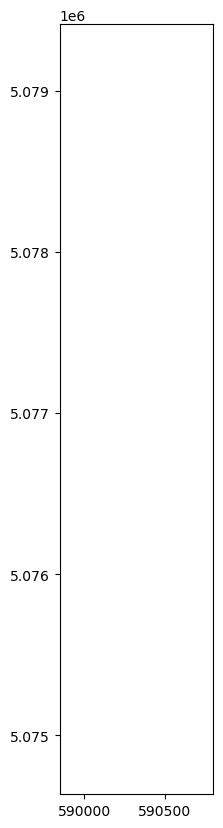

AttributeError: 'MultiPolygon' object has no attribute 'exterior'

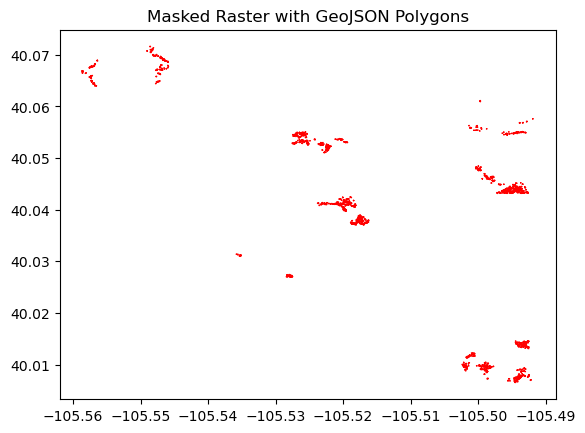

In [14]:
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio.plot import show

# File paths
geojson_path = "aop_macrosystems_data_1_7_25.geojson"
masked_raster_path = "non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance/NEON_D16_WREF_DP1_20210719_174212_reflectance__envi_resample_MicaSense-to-match_OLI_and_OLI-2_masked"

# Load the GeoJSON file
polygons = gpd.read_file(geojson_path)

# Open the masked raster file
with rasterio.open(masked_raster_path) as src:
    # Read the first band for visualization (adjust if needed)
    raster_data = src.read(1)
    
    # Plot the raster data
    plt.figure(figsize=(10, 10))
    show(raster_data, transform=src.transform, cmap="viridis")
    plt.title("Masked Raster with GeoJSON Polygons")
    
    # Overlay the polygons
    for geom in polygons.geometry:
        if not geom.is_empty:
            x, y = geom.exterior.xy  # Extract exterior boundary of the polygon
            plt.plot(x, y, color="red", linewidth=1, label="Polygon Overlay")
    
    # Add legend and display
    plt.legend(["GeoJSON Polygons"])
    plt.show()


In [13]:
import os
import glob
import rasterio
import geopandas as gpd
import numpy as np
from rasterio.features import geometry_mask

def find_reference_envi_file(envi_files, derived_file):
    """
    Finds the reference __envi file for a given derived file.

    Parameters:
    - envi_files (list): List of all __envi files in the folder.
    - derived_file (str): The derived file (e.g., .img) for which to find the reference.

    Returns:
    - str: Path to the reference __envi file, or None if not found.
    """
    base_name = os.path.basename(derived_file).split("_resample")[0]
    for envi_file in envi_files:
        if base_name in envi_file:
            return envi_file
    return None

def apply_mask_to_envi_files(folder_path, geojson_path, suffix='_masked'):
    """
    Applies a mask to all ENVI files (including .img files) in a folder and saves
    the masked output next to the original files, excluding the .img extension.

    Parameters:
    - folder_path (str): Path to the folder containing ENVI files.
    - geojson_path (str): Path to the GeoJSON file with polygons for masking.
    - suffix (str): Suffix to append to the masked file names.
    """
    # Load polygons from GeoJSON
    polygons = gpd.read_file(geojson_path)

    # Find ENVI files including those with .img extensions
    envi_files = glob.glob(os.path.join(folder_path, '*_envi'))
    derived_files = glob.glob(os.path.join(folder_path, '*.img'))
    all_files = envi_files + derived_files

    if not all_files:
        print(f"No ENVI or .img files found in folder: {folder_path}")
        return

    print(f"Found {len(all_files)} file(s) to process in {folder_path}")

    for envi_file in all_files:
        try:
            print(f"Processing file: {envi_file}")

            # Open the ENVI file
            with rasterio.open(envi_file) as src:
                if envi_file.endswith('.img'):
                    # Find corresponding __envi file for georeferencing
                    reference_envi_file = find_reference_envi_file(envi_files, envi_file)
                    if reference_envi_file:
                        print(f"Adopting georeference from {reference_envi_file}")
                        with rasterio.open(reference_envi_file) as ref_src:
                            transform = ref_src.transform
                            crs = ref_src.crs
                    else:
                        print(f"Warning: No reference ENVI file found for {envi_file}. Using default georeference.")
                        transform = src.transform
                        crs = src.crs
                else:
                    transform = src.transform
                    crs = src.crs

                # Read metadata and data
                meta = src.meta.copy()
                meta.update(transform=transform, crs=crs)
                raster_data = src.read(1)  # Assuming single-band raster, adjust if multi-band

                # Create a mask based on GeoJSON polygons
                mask = geometry_mask(
                    [geom for geom in polygons.geometry],
                    transform=transform,
                    invert=True,  # Keep pixels inside the polygons
                    out_shape=(src.height, src.width),
                )

                # Apply the mask
                masked_data = np.where(mask, raster_data, np.nan)

            # Update metadata for the output file
            meta.update(dtype='float32', nodata=np.nan)

            # Define the output path, removing the .img extension if present
            base_name = os.path.splitext(envi_file)[0]
            output_file = f"{base_name}{suffix}"

            # Save the masked raster
            with rasterio.open(output_file, 'w', **meta) as dst:
                dst.write(masked_data.astype('float32'), 1)

            print(f"Masked file saved to: {output_file}")

        except Exception as e:
            print(f"Error processing {envi_file}: {e}")


# Example Usage
folder_path = "non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance"
geojson_path = "aop_macrosystems_data_1_7_25.geojson"
apply_mask_to_envi_files(folder_path, geojson_path)


Found 8 file(s) to process in non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance
Processing file: non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance/NEON_D16_WREF_DP1_20210719_174212_reflectance__envi
Masked file saved to: non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance/NEON_D16_WREF_DP1_20210719_174212_reflectance__envi_masked
Processing file: non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance/NEON_D16_WREF_DP1_20210719_174212_reflectance__envi_resample_Landsat_5_TM.img
Adopting georeference from non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance/NEON_D16_WREF_DP1_20210719_174212_reflectance__envi


/opt/conda/envs/macrosystems/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Masked file saved to: non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance/NEON_D16_WREF_DP1_20210719_174212_reflectance__envi_resample_Landsat_5_TM_masked
Processing file: non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance/NEON_D16_WREF_DP1_20210719_174212_reflectance__envi_resample_Landsat_7_ETMplus.img
Adopting georeference from non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance/NEON_D16_WREF_DP1_20210719_174212_reflectance__envi


/opt/conda/envs/macrosystems/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Masked file saved to: non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance/NEON_D16_WREF_DP1_20210719_174212_reflectance__envi_resample_Landsat_7_ETMplus_masked
Processing file: non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance/NEON_D16_WREF_DP1_20210719_174212_reflectance__envi_resample_Landsat_8_OLI.img
Adopting georeference from non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance/NEON_D16_WREF_DP1_20210719_174212_reflectance__envi


/opt/conda/envs/macrosystems/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Masked file saved to: non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance/NEON_D16_WREF_DP1_20210719_174212_reflectance__envi_resample_Landsat_8_OLI_masked
Processing file: non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance/NEON_D16_WREF_DP1_20210719_174212_reflectance__envi_resample_Landsat_9_OLI-2.img
Adopting georeference from non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance/NEON_D16_WREF_DP1_20210719_174212_reflectance__envi


/opt/conda/envs/macrosystems/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Masked file saved to: non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance/NEON_D16_WREF_DP1_20210719_174212_reflectance__envi_resample_Landsat_9_OLI-2_masked
Processing file: non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance/NEON_D16_WREF_DP1_20210719_174212_reflectance__envi_resample_MicaSense.img
Adopting georeference from non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance/NEON_D16_WREF_DP1_20210719_174212_reflectance__envi


/opt/conda/envs/macrosystems/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Masked file saved to: non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance/NEON_D16_WREF_DP1_20210719_174212_reflectance__envi_resample_MicaSense_masked
Processing file: non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance/NEON_D16_WREF_DP1_20210719_174212_reflectance__envi_resample_MicaSense-to-match_TM_and_ETMplus.img
Adopting georeference from non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance/NEON_D16_WREF_DP1_20210719_174212_reflectance__envi


/opt/conda/envs/macrosystems/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Masked file saved to: non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance/NEON_D16_WREF_DP1_20210719_174212_reflectance__envi_resample_MicaSense-to-match_TM_and_ETMplus_masked
Processing file: non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance/NEON_D16_WREF_DP1_20210719_174212_reflectance__envi_resample_MicaSense-to-match_OLI_and_OLI-2.img
Adopting georeference from non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance/NEON_D16_WREF_DP1_20210719_174212_reflectance__envi


/opt/conda/envs/macrosystems/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Masked file saved to: non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance/NEON_D16_WREF_DP1_20210719_174212_reflectance__envi_resample_MicaSense-to-match_OLI_and_OLI-2_masked


In [25]:
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
import numpy as np
from rasterio.plot import show
from rasterio.mask import mask
from shapely.geometry import box

def plot_preserved_polygons_with_extent_fix(envi_file, geojson_file, output_file=None):
    """
    Plots the flight line ENVI raster with only the polygons preserved after masking.
    Handles cases where polygon extent is larger than the raster extent.
    
    Parameters:
    - envi_file (str): Path to the ENVI raster file.
    - geojson_file (str): Path to the GeoJSON file containing polygons.
    - output_file (str): Optional. Path to save the plot as an image.
    """
    # Load polygons
    polygons = gpd.read_file(geojson_file)

    # Open the ENVI file
    with rasterio.open(envi_file) as src:
        raster_data = src.read(1)  # Assuming single-band raster
        raster_transform = src.transform
        raster_crs = src.crs
        raster_bounds = box(*src.bounds)

        # Ensure polygons are in the same CRS as the raster
        if polygons.crs != raster_crs:
            polygons = polygons.to_crs(raster_crs)
        
        # Clip polygons to the raster extent
        polygons = gpd.clip(polygons, raster_bounds)

        # Check for intersecting polygons
        preserved_polygons = polygons[polygons.geometry.apply(lambda geom: geom.intersects(raster_bounds))]
        if preserved_polygons.empty:
            print("No polygons intersect with the raster extent.")
            return

        # Mask the raster with the polygons
        masked_data, masked_transform = mask(src, preserved_polygons.geometry, crop=True, all_touched=True, nodata=np.nan)
        masked_data = masked_data[0]  # Extract the first (and likely only) band

    # Plotting
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    
    # Plot the masked raster
    show(masked_data, transform=masked_transform, ax=ax, cmap='gray', title="Preserved Polygons on ENVI Raster")
    
    # Plot preserved polygons
    preserved_polygons.boundary.plot(ax=ax, color='red', linewidth=1.5, label='Preserved Polygons')
    
    plt.legend()
    plt.tight_layout()

    # Save or show the plot
    if output_file:
        plt.savefig(output_file, dpi=300)
        print(f"Plot saved to {output_file}")
    else:
        plt.show()



envi_file = "non_provisional_flightlines_NIWO/NEON_D13_NIWO_DP1_20200731_151902_reflectance/NEON_D13_NIWO_DP1_20200731_151902_reflectance__envi"
geojson_file = "aop_macrosystems_data_1_7_25.geojson"
output_file = "tester_output_plot.png"  # Optional

plot_preserved_polygons(envi_file, geojson_file, output_file)

ValueError: Input shapes do not overlap raster.

Loaded 4395 polygons from aop_macrosystems_data_1_7_25.geojson.
Raster CRS: EPSG:32613
Raster Bounds: BoundingBox(left=449118.0, bottom=4433223.0, right=460110.0, top=4434623.0)
Reprojecting polygons to match raster CRS...
Reprojection complete.
Clipping polygons to raster bounds...
Number of polygons after clipping: 366
Set plot limits to raster bounds to zoom in.


/tmp/ipykernel_63236/1895827406.py:72: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper right')


Plot saved to tester_output_plot_zoomed.png


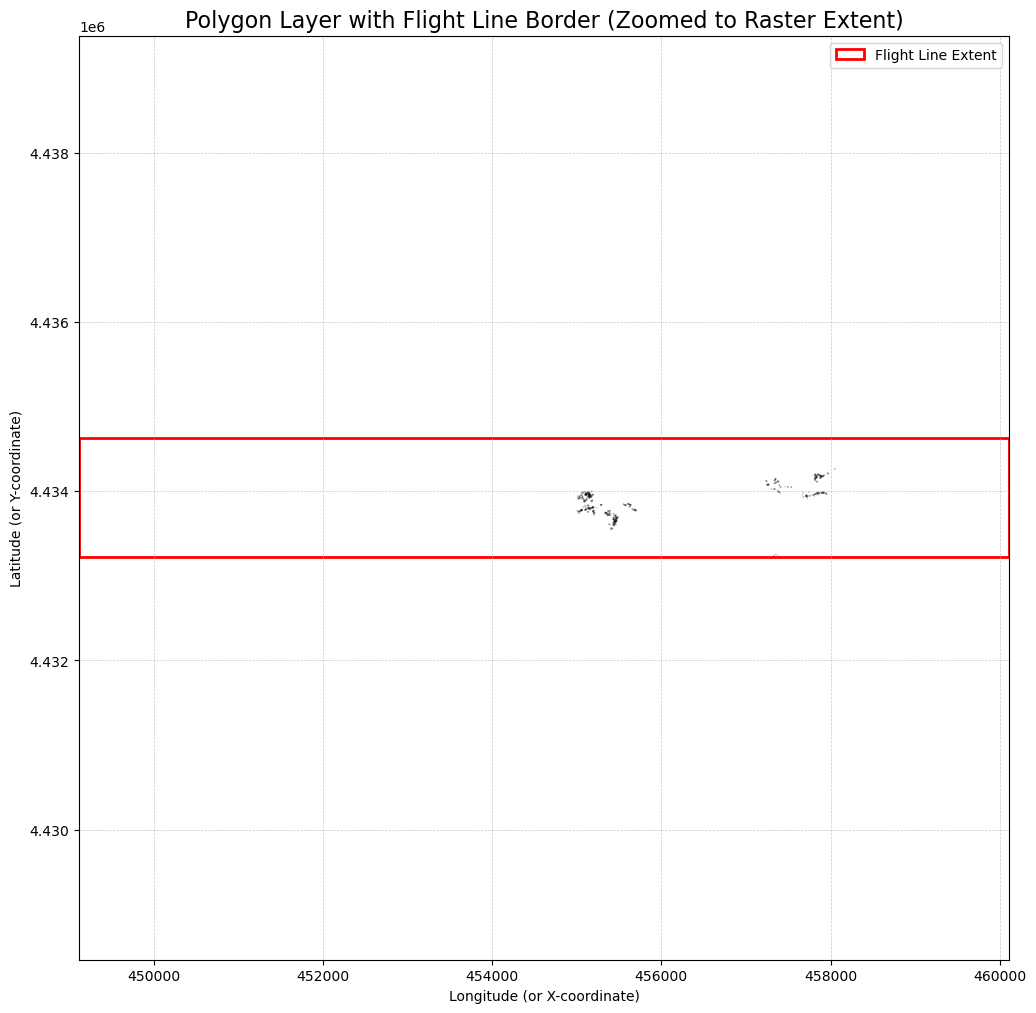

In [10]:
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
from shapely.geometry import box
from matplotlib.patches import Rectangle

def plot_polygons_with_flight_line_border(envi_file, geojson_file, output_file=None, clip_polygons=True):
    """
    Plots the polygon layer with the flight line raster extent as a border overlaid.
    The plot is zoomed to the extent of the raster.

    Parameters:
    - envi_file (str): Path to the ENVI raster file.
    - geojson_file (str): Path to the GeoJSON file containing polygons.
    - output_file (str): Optional. Path to save the plot as an image.
    - clip_polygons (bool): Optional. If True, clips polygons to raster bounds before plotting.
    """
    # Load the polygon layer
    polygons = gpd.read_file(geojson_file)
    print(f"Loaded {len(polygons)} polygons from {geojson_file}.")

    # Get the raster extent and CRS
    with rasterio.open(envi_file) as src:
        raster_crs = src.crs
        raster_bounds = box(*src.bounds)  # Convert raster bounds to a Shapely polygon
        raster_bounds_coords = src.bounds  # (left, bottom, right, top)
        print(f"Raster CRS: {raster_crs}")
        print(f"Raster Bounds: {raster_bounds_coords}")

    # Ensure CRS alignment
    if polygons.crs != raster_crs:
        print("Reprojecting polygons to match raster CRS...")
        polygons = polygons.to_crs(raster_crs)
        print("Reprojection complete.")
    else:
        print("Polygons CRS matches raster CRS. No reprojection needed.")

    # Optionally clip polygons to raster bounds
    if clip_polygons:
        print("Clipping polygons to raster bounds...")
        # Create a GeoDataFrame for the raster bounds
        raster_bounds_gdf = gpd.GeoDataFrame({'geometry': [raster_bounds]}, crs=raster_crs)
        # Perform spatial overlay (intersection)
        clipped_polygons = gpd.overlay(polygons, raster_bounds_gdf, how='intersection')
        print(f"Number of polygons after clipping: {len(clipped_polygons)}")
    else:
        clipped_polygons = polygons
        print("Clipping skipped. All polygons will be plotted.")

    # Check if there are any polygons to plot
    if clipped_polygons.empty:
        print("No polygons overlap the raster extent. Exiting plot function.")
        return

    # Plot the polygons
    fig, ax = plt.subplots(figsize=(12, 12))
    clipped_polygons.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5, label='Polygons')

    # Plot the flight line extent as a red border
    flight_line_patch = Rectangle(
        (raster_bounds_coords.left, raster_bounds_coords.bottom),  # Lower-left corner
        raster_bounds_coords.right - raster_bounds_coords.left,  # Width
        raster_bounds_coords.top - raster_bounds_coords.bottom,    # Height
        linewidth=2, edgecolor='red', facecolor='none', label='Flight Line Extent', alpha=1
    )
    ax.add_patch(flight_line_patch)

    # Customize the plot
    ax.set_title("Polygon Layer with Flight Line Border (Zoomed to Raster Extent)", fontsize=16)
    ax.set_xlabel("Longitude (or X-coordinate)")
    ax.set_ylabel("Latitude (or Y-coordinate)")
    ax.legend(loc='upper right')
    ax.set_aspect('equal', adjustable='datalim')

    # Set the axis limits to raster bounds to zoom in
    ax.set_xlim(raster_bounds_coords.left, raster_bounds_coords.right)
    ax.set_ylim(raster_bounds_coords.bottom, raster_bounds_coords.top)
    print("Set plot limits to raster bounds to zoom in.")

    # Optional: Add grid for better spatial reference
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Save or show the plot
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"Plot saved to {output_file}")
    
    plt.show()

    plt.close(fig)  # Close the figure to free memory

# Example usage
if __name__ == "__main__":
    envi_file = "non_provisional_flightlines_NIWO/NEON_D13_NIWO_DP1_20200731_151902_reflectance/NEON_D13_NIWO_DP1_20200731_151902_reflectance__envi"
    geojson_file = "aop_macrosystems_data_1_7_25.geojson"
    output_file = "tester_output_plot_zoomed.png"  # Optional

    plot_polygons_with_flight_line_border(envi_file, geojson_file, output_file)


In [ ]:
import os
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
import numpy as np
import matplotlib.pyplot as plt
from rasterio.crs import CRS
from rasterio.warp import calculate_default_transform, reproject, Resampling

def load_data(envi_path, geojson_path):
    """
    Loads the ENVI raster and GeoJSON polygons.
    """
    if not os.path.exists(envi_path):
        raise FileNotFoundError(f"ENVI raster file not found at: {envi_path}")
    if not os.path.exists(geojson_path):
        raise FileNotFoundError(f"GeoJSON file not found at: {geojson_path}")

    raster = rasterio.open(envi_path)
    polygons = gpd.read_file(geojson_path)
    return raster, polygons


def assign_crs(raster, polygons, raster_crs_override=None, polygons_crs_override=None):
    """
    Assigns CRS to raster and polygons if undefined.
    """
    if raster.crs is None:
        if raster_crs_override is not None:
            raster.crs = CRS.from_string(raster_crs_override)
            print(f"Assigned CRS {raster_crs_override} to raster.")
        else:
            raise ValueError("Raster CRS is undefined and no override provided.")

    if polygons.crs is None:
        if polygons_crs_override is not None:
            polygons.crs = polygons_crs_override
            print(f"Assigned CRS {polygons_crs_override} to polygons.")
        else:
            raise ValueError("Polygons CRS is undefined and no override provided.")

    return raster, polygons


def align_crs_debug(raster, polygons):
    """
    Reprojects polygons to match raster CRS with debug outputs.
    """
    print("Raster CRS:", raster.crs)
    print("Polygons CRS:", polygons.crs)

    if polygons.crs != raster.crs:
        print("Reprojecting polygons to match raster CRS...")
        polygons_aligned = polygons.to_crs(raster.crs)
        print("Reprojection complete.")
    else:
        print("CRS of raster and polygons already match.")
        polygons_aligned = polygons

    print("Raster Bounds:", raster.bounds)
    print("Polygons Bounds After Alignment:", polygons_aligned.total_bounds)
    return polygons_aligned


def clip_polygons_debug(raster, polygons_aligned):
    """
    Clips polygons to raster bounds with debug outputs.
    """
    print("Clipping polygons to raster bounds...")
    raster_bounds_geom = gpd.GeoDataFrame({'geometry': [box(*raster.bounds)]}, crs=raster.crs)
    clipped_polygons = gpd.overlay(polygons_aligned, raster_bounds_geom, how='intersection')
    if clipped_polygons.empty:
        print("No polygons overlap the raster extent.")
    else:
        print(f"Number of Clipped Polygons: {len(clipped_polygons)}")
        print("Clipped Polygons Bounds:", clipped_polygons.total_bounds)
    return clipped_polygons


def create_mask(raster, polygons):
    """
    Creates a mask where pixels inside polygons are True and outside are False.
    """
    print("Creating mask from polygons...")
    mask = rasterize(
        [(geom, 1) for geom in polygons.geometry],
        out_shape=(raster.height, raster.width),
        transform=raster.transform,
        fill=0,  # Background value
        dtype='uint8',
        all_touched=True  # Include all touched pixels
    )
    mask = mask.astype(bool)
    print(f"Mask created with shape {mask.shape}. Inside pixels: {np.sum(mask)}")
    
    # Additional debug: Check unique values
    unique_values = np.unique(mask)
    print(f"Unique values in mask: {unique_values}")
    
    return mask


def apply_mask(raster, mask):
    """
    Applies the mask to raster data, setting areas outside polygons to nodata.
    """
    raster_data = raster.read()
    nodata_value = raster.nodata if raster.nodata is not None else -9999
    print(f"Using nodata value: {nodata_value}")

    if raster.count > 1:  # For multi-band rasters
        if mask.shape != raster.read(1).shape:
            raise ValueError("Mask shape does not match raster band shape.")
        mask_expanded = np.repeat(mask[np.newaxis, :, :], raster.count, axis=0)
        masked_data = np.where(mask_expanded, raster_data, nodata_value)
    else:  # For single-band rasters
        masked_data = np.where(mask, raster_data[0], nodata_value)

    print(f"Masked data shape: {masked_data.shape}")
    return masked_data


def save_masked_raster(envi_path, masked_data, nodata, raster):
    """
    Saves the masked raster to a new file.
    """
    base_name, ext = os.path.splitext(envi_path)
    output_file = f"{base_name}_masked{ext}"
    meta = raster.meta.copy()
    meta.update({
        'dtype': masked_data.dtype,
        'nodata': nodata,
        'count': raster.count if raster.count > 1 else 1
    })

    with rasterio.open(output_file, 'w', **meta) as dst:
        if raster.count > 1:
            for i in range(raster.count):
                dst.write(masked_data[i], i + 1)
        else:
            dst.write(masked_data, 1)
    print(f"Masked raster saved to: {output_file}")


def plot_results_debug(raster, masked_data, nodata, polygons_aligned, clipped_polygons, masked_raster_path):
    """
    Plots the original raster, clipped polygons, clipped polygons on raster, and masked raster.
    Includes debug output for alignment issues, saves the result as a high-resolution PNG,
    and displays the plot.
    """
    output_folder = os.path.dirname(masked_raster_path)
    output_path = os.path.join(output_folder, "plot_results.png")

    print(f"Masked data stats: Min={masked_data.min()}, Max={masked_data.max()}, Unique={np.unique(masked_data)}")

    fig, axes = plt.subplots(2, 2, figsize=(18, 12))

    # Original Raster
    original = raster.read(1)
    original = np.ma.masked_equal(original, nodata)
    axes[0, 0].imshow(original, cmap='gray', extent=(raster.bounds.left, raster.bounds.right, raster.bounds.bottom, raster.bounds.top))
    axes[0, 0].set_title('Original Raster')
    axes[0, 0].axis('off')

    # Clipped Polygons
    clipped_polygons.plot(ax=axes[0, 1], facecolor='none', edgecolor='red')
    axes[0, 1].set_title('Clipped Polygons')
    axes[0, 1].set_xlim(raster.bounds.left, raster.bounds.right)
    axes[0, 1].set_ylim(raster.bounds.bottom, raster.bounds.top)
    axes[0, 1].axis('off')

    # Clipped Polygons on Raster
    axes[1, 0].imshow(original, cmap='gray', extent=(raster.bounds.left, raster.bounds.right, raster.bounds.bottom, raster.bounds.top))
    clipped_polygons.plot(ax=axes[1, 0], facecolor='none', edgecolor='blue', linewidth=0.5)
    axes[1, 0].set_title('Clipped Polygons on Raster')
    axes[1, 0].set_xlim(raster.bounds.left, raster.bounds.right)
    axes[1, 0].set_ylim(raster.bounds.bottom, raster.bounds.top)
    axes[1, 0].axis('off')

    # Masked Raster
    # Find the first valid band to plot
    valid_band_found = False
    for band_index in range(masked_data.shape[0]):
        band = np.ma.masked_equal(masked_data[band_index], nodata)
        if np.any(band):  # Check if the band has non-nodata values
            print(f"Plotting band {band_index + 1} (valid band found).")
            valid_band_found = True
            axes[1, 1].imshow(band, cmap='Reds', extent=(raster.bounds.left, raster.bounds.right, raster.bounds.bottom, raster.bounds.top))
            axes[1, 1].set_title(f'Masked Raster (Band {band_index + 1})')
            axes[1, 1].axis('off')
            break

    if not valid_band_found:
        print("No valid band found to plot.")
        axes[1, 1].text(0.5, 0.5, "No valid band found", ha='center', va='center', transform=axes[1, 1].transAxes)

    plt.tight_layout()

    # Save the figure
    print(f"Saving plot to {output_path}")
    plt.savefig(output_path, dpi=300)  # Save as high-resolution PNG

    # Display the plot
    plt.show()


def main_debug(envi_path, geojson_path):
    """
    Main function with additional debug outputs.
    """
    raster, polygons = load_data(envi_path, geojson_path)

    # Handle undefined CRS
    raster, polygons = assign_crs(raster, polygons)

    # Align polygons to raster CRS with debug
    polygons_aligned = align_crs_debug(raster, polygons)

    # Clip polygons to raster bounds with debug
    clipped_polygons = clip_polygons_debug(raster, polygons_aligned)

    if clipped_polygons.empty:
        print("No polygons overlap the raster extent. Exiting...")
        return

    # Create mask
    mask = create_mask(raster, clipped_polygons)

    # Apply mask to raster
    masked_data = apply_mask(raster, mask)

    # Get the masked raster path
    masked_raster_path = f"{envi_path}_masked"

    # Plot results
    plot_results_debug(raster, masked_data, raster.nodata, polygons_aligned, clipped_polygons, masked_raster_path)

    # Save masked raster
    save_masked_raster(envi_path, masked_data, raster.nodata, raster)


# Example usage
if __name__ == "__main__":
    from shapely.geometry import box

    envi_path = 'non_provisional_flightlines_NIWO/NEON_D13_NIWO_DP1_20200731_151902_reflectance/NEON_D13_NIWO_DP1_20200731_151902_reflectance__envi'
    geojson_path = 'aop_macrosystems_data_1_7_25.geojson'
    main_debug(envi_path, geojson_path)


Raster CRS: EPSG:32613
Polygons CRS: EPSG:4326
Reprojecting polygons to match raster CRS...
Reprojection complete.
Raster Bounds: BoundingBox(left=449118.0, bottom=4433223.0, right=460110.0, top=4434623.0)
Polygons Bounds After Alignment: [-822547.87347454 4426034.20421104  458049.26777551 5221581.72101893]
Clipping polygons to raster bounds...
Number of Clipped Polygons: 366
Clipped Polygons Bounds: [ 455004.13772163 4433223.          458049.26777551 4434268.09674941]
Creating mask from polygons...
Mask created with shape (1400, 10992). Inside pixels: 8771
Unique values in mask: [False  True]
Using nodata value: -9999.0
Masked data shape: (426, 1400, 10992)


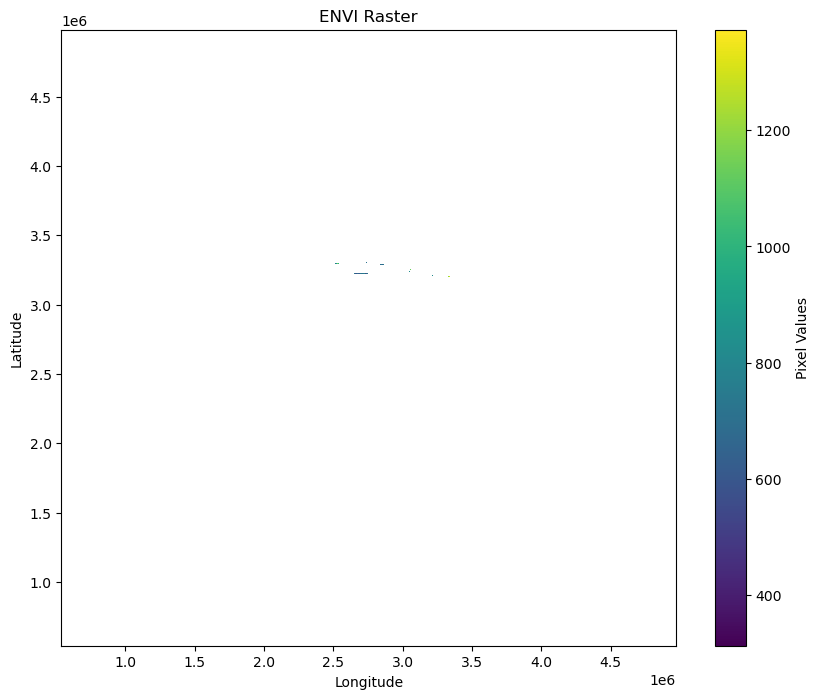

In [7]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

def plot_envi_raster(file_path):
    """
    Reads and plots an ENVI raster file.

    Parameters:
    - file_path: Path to the ENVI raster file.
    """
    try:
        with rasterio.open(file_path) as src:
            # Read the first band (or modify as needed for specific bands)
            data = src.read(1)  # Read the first band
            data = np.ma.masked_equal(data, src.nodata)  # Mask nodata values

            # Plot the raster
            plt.figure(figsize=(10, 8))
            plt.imshow(data, cmap='viridis', extent=src.bounds, interpolation='nearest')
            plt.colorbar(label='Pixel Values')
            plt.title('ENVI Raster')
            plt.xlabel('Longitude')
            plt.ylabel('Latitude')
            plt.grid(False)
            plt.show()

    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"An error occurred: {e}")

# Replace with your ENVI raster file path
envi_path = 'non_provisional_flightlines_YELL/NEON_D12_YELL_DP1_L035-1_20220626_directional_reflectance/NEON_D12_YELL_DP1_L035-1_20220626_directional_reflectance_masked'
plot_envi_raster(envi_path)


In [9]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize

def plot_masked_raster(masked_data, transform, nodata=None, bands_to_plot=None, output_path=None):
    """
    Plots the masked raster data.

    Parameters:
    - masked_data: numpy array
        Masked raster data. Shape should be (bands, height, width) for multi-band or (height, width) for single-band.
    - transform: affine.Affine
        The affine transform of the raster, used to calculate the spatial extent.
    - nodata: float or int, optional
        The nodata value used in the raster. Areas with this value will be masked.
    - bands_to_plot: list of int, optional
        List of band indices to plot (1-based). 
        - If None, the first band is plotted for single-band rasters.
        - For RGB visualization in multi-band rasters, provide a list like [1, 2, 3].
    - output_path: str, optional
        If provided, the plot will be saved to this path.
    
    Returns:
    - None
    """
    # Determine if raster is multi-band or single-band
    if masked_data.ndim == 3:
        is_multiband = True
        num_bands, height, width = masked_data.shape
    elif masked_data.ndim == 2:
        is_multiband = False
        height, width = masked_data.shape
    else:
        raise ValueError("masked_data must be a 2D or 3D numpy array.")

    # Calculate spatial extent from transform
    left, top = transform * (0, 0)
    right, bottom = transform * (width, height)
    extent = (left, right, bottom, top)

    plt.figure(figsize=(10, 10))

    if is_multiband:
        if bands_to_plot is None:
            # Default to plotting the first band
            bands_to_plot = [1]
        
        if len(bands_to_plot) == 1:
            # Single band plot
            band_index = bands_to_plot[0] - 1  # Convert to 0-based index
            band = masked_data[band_index]
            if nodata is not None:
                band = np.ma.masked_equal(band, nodata)
            plt.imshow(band, cmap='gray', extent=extent)
            plt.title(f'Masked Raster - Band {bands_to_plot[0]}')
            plt.axis('off')
        
        elif len(bands_to_plot) == 3:
            # RGB Composite
            rgb = []
            for band_num in bands_to_plot:
                band = masked_data[band_num - 1].astype(float)
                if nodata is not None:
                    band = np.ma.masked_equal(band, nodata)
                # Normalize each band for display
                band_min, band_max = np.nanmin(band), np.nanmax(band)
                if band_max > band_min:
                    band = (band - band_min) / (band_max - band_min)
                else:
                    band = band  # Avoid division by zero if band_max == band_min
                rgb.append(band)
            rgb = np.dstack(rgb)
            plt.imshow(rgb, extent=extent)
            plt.title('Masked Raster - RGB Composite')
            plt.axis('off')
        
        else:
            raise ValueError("For multi-band rasters, bands_to_plot must have 1 or 3 band indices.")
    else:
        # Single-band raster
        band = masked_data
        if nodata is not None:
            band = np.ma.masked_equal(band, nodata)
        plt.imshow(band, cmap='gray', extent=extent)
        plt.title('Masked Raster')
        plt.axis('off')

    plt.tight_layout()

    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Masked raster plot saved to: {output_path}")

    plt.show()
